# 2022 Comparative analysis benchmark

Logbook: https://docs.google.com/document/d/1NsqY_mA7U-jY2aLQlaQimiNLaRvYVx26cAia8HTdG_M/edit#


In [230]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd

import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os, re
import glob
from tqdm.auto import tqdm
import tempfile
from itertools import product


In [231]:
# MODIFICATIONS = [
#     'H3K4me2', 'H3K4me3', 'H3K9ac' 'H3K27ac', # narrow
#     'H3K4me1', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K79me2', # broad
#     'H3K4ac', 'H3K56ac', 'H3K79me1' # mixed
# ]

# Core histone marks
MODIFICATIONS = [
    'H3K4me3', 'H3K4me1', 'H3K27me3', 'H3K36me3'
]

PATH = os.path.expanduser('~/data/2022_comparative_analysis')
FIGURES_DIR = os.path.join(PATH, 'pics')
EXT = 'pdf'
! mkdir -p {FIGURES_DIR}

In [232]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

## MACS2

In [233]:
MACS2_FOLDER = f'{PATH}/macs2'
MACS2_LEVELS = ['q0.05', 'broad0.1']

dfm = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(MACS2_FOLDER + '/*.*Peak')):
    if 'gapped' in file:
        continue
    level = next((l for l in MACS2_LEVELS if f'_{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfm.loc[len(dfm)] = (modification, replicate, f'macs2 {level}', file, peaks)

  0%|          | 0/111 [00:00<?, ?it/s]

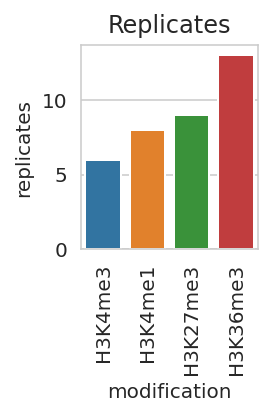

In [234]:
t = (dfm.groupby(['modification'])['file'].count() / len(MACS2_LEVELS)).astype(int)
plt.figure(figsize=(2, 3))
sns.barplot(data=pd.DataFrame(dict(modification=t.index, replicates=t)), x='modification', y='replicates',
            order=MODIFICATIONS)
plt.xticks(rotation=90)
plt.title('Replicates')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'replicates_macs2.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [235]:
macs2levels2process = {'macs2 q0.05', 'macs2 broad0.1'}

## SICER

In [236]:
SICER_FOLDER = f'{PATH}/sicer'
SICER_LEVELS = ['FDR0.01']

dfsc = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SICER_FOLDER + '/*islands-summary*')):
    level = next((l for l in SICER_LEVELS if f'-{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfsc.loc[len(dfsc)] = (modification, replicate, f'sicer {level}', file, peaks)

  0%|          | 0/37 [00:00<?, ?it/s]

In [237]:
sicerlevels2process = {'sicer FDR0.01'}

## SPAN

In [238]:
SPAN_FOLDER = f'{PATH}/span'
GAPS = [3]
FDRS = ['0.05']
SPAN_LEVELS = list(f'100_{fdr}_{gap}' for fdr, gap in product(FDRS, GAPS))

dfs = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SPAN_FOLDER + '/*.peak')):
    if 'Input' in file:
        continue
    level = next((l for l in SPAN_LEVELS if f'_{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfs.loc[len(dfs)] = (modification, replicate, f'span {level}', file, peaks)

  0%|          | 0/37 [00:00<?, ?it/s]

In [239]:
import re

dfs['fdr'] = [float(re.sub('span 100_|_[0-9]+', '', l)) for l in dfs['level']]
dfs['gap'] = [int(re.sub('.*_', '', l)) for l in dfs['level']]
dfs.sort_values(by=['fdr', 'gap'], inplace=True)
dfs.head()

,modification,replicate,level,file,peaks,fdr,gap
0,H3K27me3,1_1,span 100_0.05_3,/home/jetbrains/data/2022_comparative_analysis...,13958,0.05,3
1,H3K4me1,4_1,span 100_0.05_3,/home/jetbrains/data/2022_comparative_analysis...,91546,0.05,3
2,H3K36me3,7_1,span 100_0.05_3,/home/jetbrains/data/2022_comparative_analysis...,43324,0.05,3
3,H3K4me1,4_2,span 100_0.05_3,/home/jetbrains/data/2022_comparative_analysis...,115118,0.05,3
4,H3K4me1,2_1,span 100_0.05_3,/home/jetbrains/data/2022_comparative_analysis...,42901,0.05,3


In [240]:
spanlevels2process = {'span 100_0.05_3'}

## Summary

In [241]:
dfa = pd.concat([
    dfm.loc[[l in macs2levels2process for l in dfm['level']]],
    dfs.loc[[l in spanlevels2process for l in dfs['level']]],
    dfsc.loc[[l in sicerlevels2process for l in dfsc['level']]],
])

dfa['name'] = ''
dfa.loc[dfa['level'] == 'macs2 q0.05', 'name'] = 'MACS2'
dfa.loc[dfa['level'] == 'macs2 broad0.1', 'name'] = 'MACS2 broad'
dfa.loc[dfa['level'] == 'sicer FDR0.01', 'name'] = 'SICER'
dfa.loc[dfa['level'] == 'span 100_0.05_3', 'name'] = 'SPAN'
dfa.sample(5)

,modification,replicate,level,file,peaks,fdr,gap,name
40,H3K36me3,2_2,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,24825,NaN,NaN,MACS2
23,H3K36me3,2_1,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,19445,NaN,NaN,SICER
61,H3K4me1,5_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,1428,NaN,NaN,MACS2
32,H3K36me3,6_1,span 100_0.05_3,/home/jetbrains/data/2022_comparative_analysis...,20148,0.05,3.0,SPAN
30,H3K27me3,7_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,52579,NaN,NaN,MACS2


# Group analysis

In [242]:
def plot_data_cells(
        df, cid, value, description, bar=True, swarm=True, order=None, lower=None, upper=None, figx=None, figy=None
):
    cids = list(set(df[cid]))
    axs = {}
    total = len(cids) * len(MODIFICATIONS)
    plt.figure(figsize=(figx or int(total / 3), figy or 4))
    offset = 0
    for m in MODIFICATIONS:
        data = df.loc[df['modification'] == m].sort_values(by=[cid])
        w = len(cids)
        ax = plt.subplot2grid((1, total), (0, offset), colspan=w)

        if bar:
            sns.barplot(data=data,
                        x=cid, y=value,
                        capsize=.2, errwidth=2,
                        ax=ax,
                        order=order)
        else:
            sns.boxplot(data=data, x=cid, y=value, showfliers=False, ax=ax,
                        order=order)
        if swarm:
            sns.swarmplot(data=data,
                          x=cid, y=value,
                          size=4,
                          color="black",
                          alpha=0.8,
                          ax=ax,
                          order=order)

            # ax.legend().remove()
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel(description)

        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        ax.xaxis.set_tick_params(rotation=90)

    ymin = np.min([v[0] for v in axs.values()])
    if lower is not None:
        ymin = max(ymin, lower)
    ymax = np.max([v[1] for v in axs.values()])
    if upper is not None:
        ymax = min(ymax, upper)

    for ax in axs.keys():
        ax.set_ylim(bottom=ymin, top=ymax)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{value}.{EXT}'), bbox_inches='tight', dpi=300)
    plt.show()


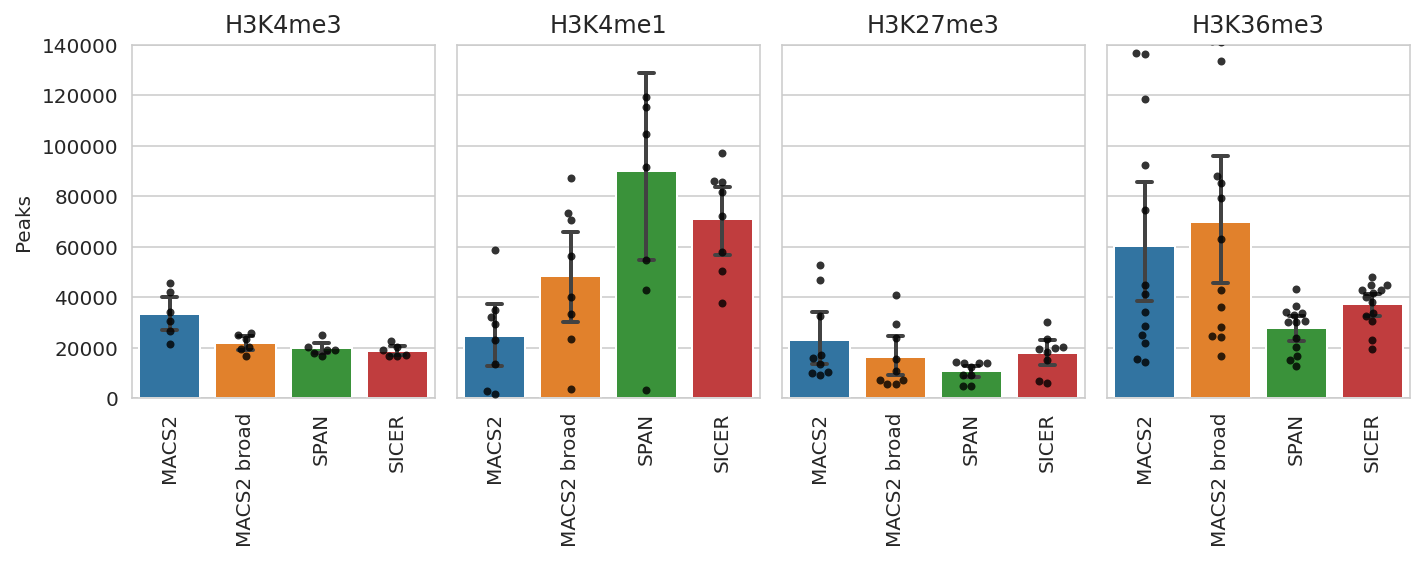

In [243]:
plot_data_cells(dfa, 'name', 'peaks', 'Peaks', upper=140_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

In [244]:
dfa[(dfa['modification'] == 'H3K4me1') & (dfa['peaks']< 10000)]

# Filter out bad quality and super high quality data
dfa = dfa[~((dfa['modification'] == 'H3K4me1') & ((dfa['replicate'] == '1_1') |
                                                  (dfa['replicate'] == '1_2')))]
dfa = dfa[~((dfa['modification'] == 'H3K27me3') & (dfa['replicate'] == '1_1'))]
dfa = dfa[~((dfa['modification'] == 'H3K36me3') & ((dfa['replicate'] == '1_1') |
                                                  (dfa['replicate'] == '2_1')))]

dfa

,modification,replicate,level,file,peaks,fdr,gap,name
0,H3K36me3,4_2,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,28534,NaN,NaN,MACS2
1,H3K27me3,4_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,6995,NaN,NaN,MACS2 broad
2,H3K4me1,5_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,3553,NaN,NaN,MACS2 broad
3,H3K4me1,3_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,87050,NaN,NaN,MACS2 broad
4,H3K4me1,4_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,13398,NaN,NaN,MACS2
...,...,...,...,...,...,...,...,...
30,H3K36me3,4_2,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,38246,NaN,NaN,SICER
31,H3K36me3,5_1,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,44840,NaN,NaN,SICER
32,H3K4me3,1_1,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,19069,NaN,NaN,SICER
33,H3K27me3,1_2,sicer FDR0.01,/home/jetbrains/data/2022_comparative_analysis...,20129,NaN,NaN,SICER


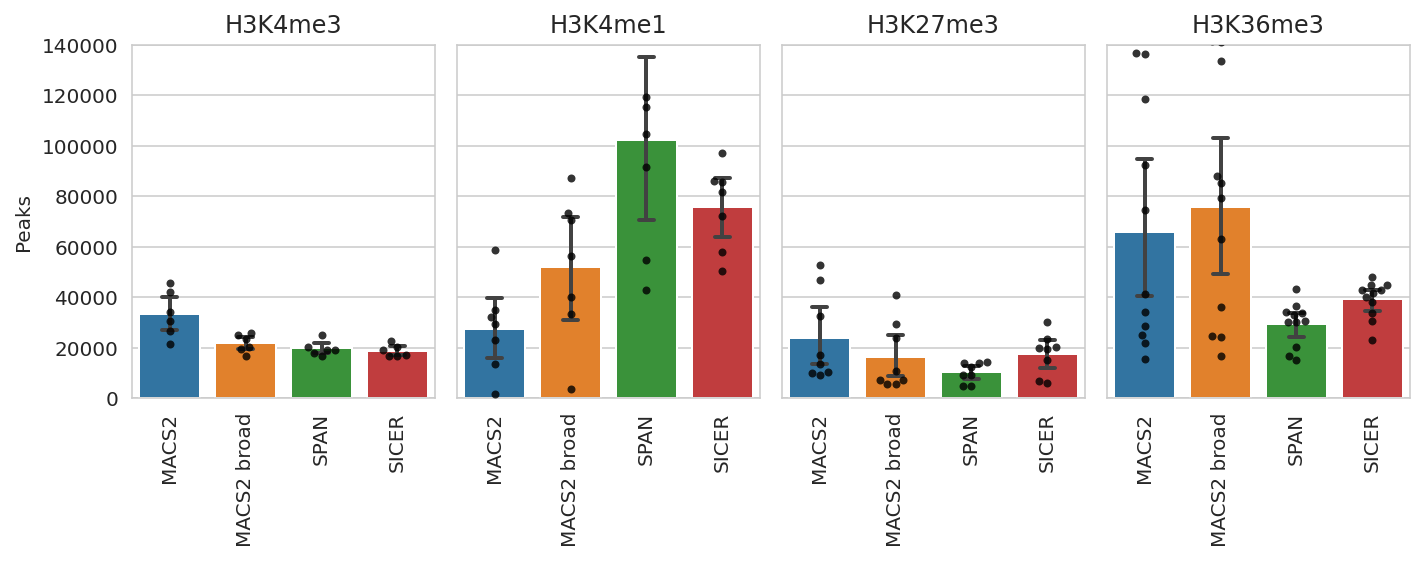

In [265]:
plot_data_cells(dfa, 'name', 'peaks', 'Peaks', upper=140_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

In [246]:
ts = []
for modification, name, file in tqdm(zip(dfa['modification'], dfa['name'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t['modification'] = modification
    t['name'] = name
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,modification,name
719877,2477,H3K36me3,SPAN
650387,2377,H3K4me1,SPAN
448808,101,H3K4me1,MACS2 broad
40055,134,H3K4me1,MACS2
934702,1199,H3K4me1,SICER
457668,1418,H3K4me3,MACS2 broad
614561,1077,H3K4me1,SPAN
163864,192,H3K36me3,MACS2
718866,6217,H3K27me3,SPAN
712234,882,H3K27me3,SPAN


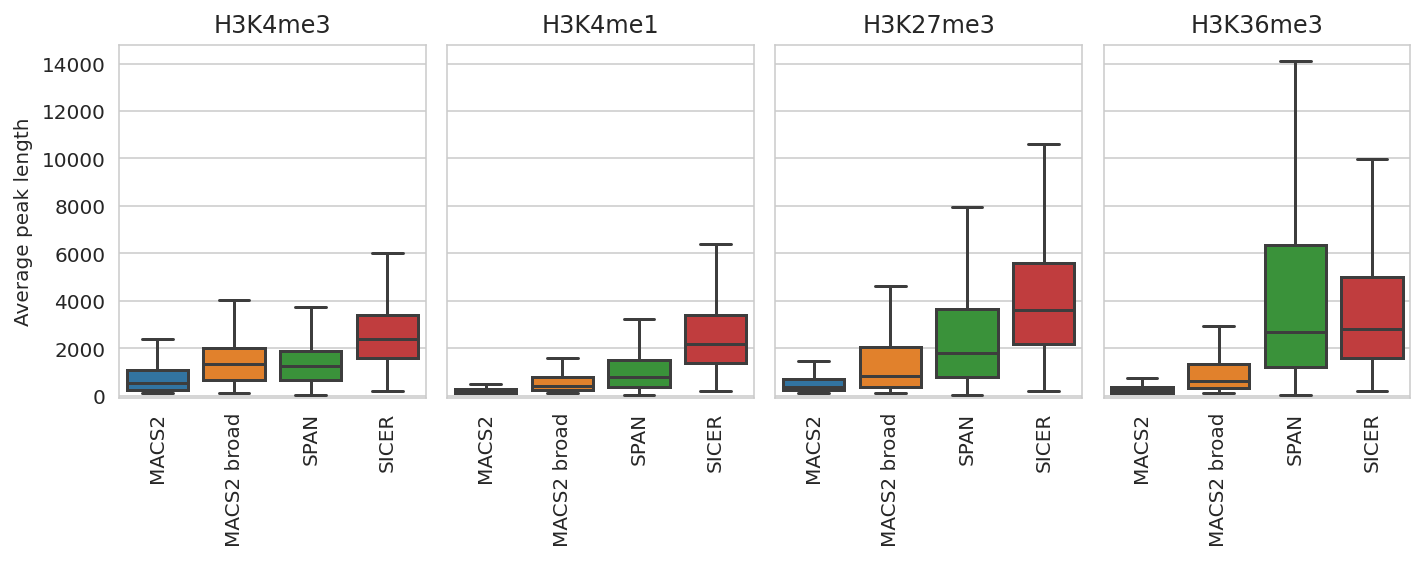

In [247]:
plot_data_cells(t, 'name', 'length', 'Average peak length', bar=False, swarm=False, 
                lower=-100, upper=15_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

# Difference between tools

In [248]:

diff_df = pd.DataFrame(
    columns=['modification', 'replicate', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

tools = list(sorted(set(dfa['name'])))
for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa.loc[dfa['modification'] == m]
    reps = list(sorted(set(tm['replicate'])))
    for rep in reps:
        for i in range(len(tools)):
            for j in range(i + 1, len(tools)):
                tool1, tool2 = tools[i], tools[j]
                if tool1 != 'SPAN' and tool2 != 'SPAN':
                    continue
                t1 = tm.loc[(tm['name'] == tool1) & (tm['replicate'] == rep)]
                t2 = tm.loc[(tm['name'] == tool2) & (tm['replicate'] == rep)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                name = f'{tool1} - {tool2}'
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                tf = tempfile.mktemp()
                ! bedtools intersect -a {file1} -b {file2} -wa -v > {tf}
                peaks = lines(tf)
                diff_df.loc[len(diff_df)] = \
                    (m, rep, name, peaks)
diff_df.sample(5)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


,modification,replicate,name,peaks
86,H3K36me3,5_4,SICER - SPAN,2834
81,H3K36me3,5_3,MACS2 - SPAN,15
72,H3K36me3,4_2,MACS2 - SPAN,0
23,H3K4me1,3_1,SICER - SPAN,2241
64,H3K36me3,2_2,MACS2 broad - SPAN,23312


In [249]:
diff_dfa = pd.concat([diff_df, dfa[['modification', 'replicate', 'name', 'peaks']]]).reset_index(drop=True)
diff_dfa.sample(5)

,modification,replicate,name,peaks
30,H3K4me1,4_3,MACS2 - SPAN,1541
6,H3K4me3,3_1,MACS2 - SPAN,475
92,H3K36me3,6_1,SICER - SPAN,1186
168,H3K27me3,6_1,SPAN,12260
157,H3K36me3,5_3,MACS2 broad,62943


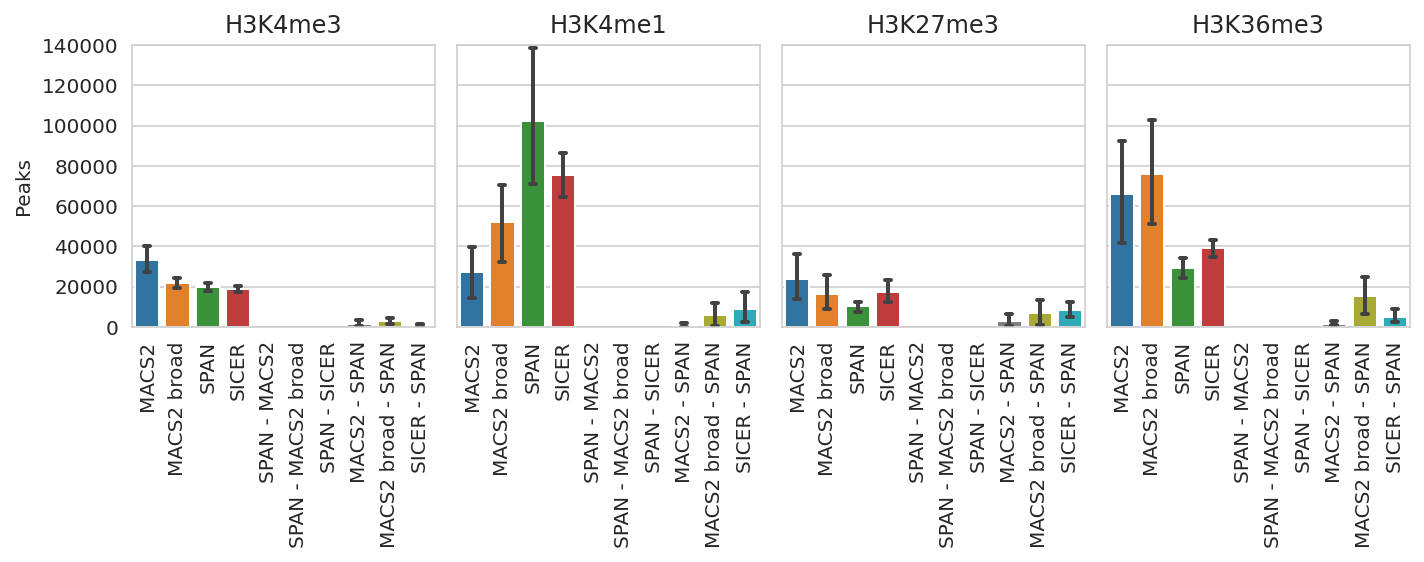

In [250]:
plot_data_cells(diff_dfa, 'name', 'peaks', 'Peaks', swarm=False, upper=140_000, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])

# Consistency analysis between replicates

In [253]:
import tempfile

reps_overlap = pd.DataFrame(columns=['modification', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks2', 'length1', 'length2',
                                     'overlap1', 'overlap2', 'intersect_length'], dtype=object)

# Use only 5 replicates for now
for m in MODIFICATIONS:
    print(m)
    tm = dfa[dfa['modification'] == m]
    for tool in tqdm(list(sorted(set(tm['name'])))):
        reps = list(sorted(tm[tm['name'] == tool]['replicate'].unique()))
        for i in range(min(5, len(reps))):
            for j in range(i + 1, min(5, len(reps))):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['name'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['name'] == tool) & (tm['replicate'] == rep2)]
                # print(m, tool, rep1, rep2, len(t1), len(t2))
                file1 = sorted_file(t1['file'].values[0])
                peaks1, length1 = t1['peaks'].values[0], bedl(file1).sum()
                file2 = sorted_file(t2['file'].values[0])
                peaks2, length2 = t2['peaks'].values[0], bedl(file2).sum()
                tf = tempfile.mktemp()
                ! bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                ! bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                ! bedtools intersect -a {file1} -b {file2} -wo > {tf}
                intersection_length = int(last_col(tf).sum())
                reps_overlap.loc[len(reps_overlap)] = \
                    (m, tool, rep1, rep2, peaks1, peaks2, length1, length2,
                        overlap1, overlap2, intersection_length)

H3K4me3


  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me1


  0%|          | 0/4 [00:00<?, ?it/s]

H3K27me3


  0%|          | 0/4 [00:00<?, ?it/s]

H3K36me3


  0%|          | 0/4 [00:00<?, ?it/s]

In [254]:
# TODO use melt() here!
ro = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'Overlap'], dtype=object)
for _, row in reps_overlap.iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap1 = row['overlap1']
    overlap2 = row['overlap2']
    ro.loc[len(ro)] = (m, f'{rep1} vs {rep2}', tool, d(overlap1, peaks1))
    ro.loc[len(ro)] = (m, f'{rep2} vs {rep1}', tool, d(overlap2, peaks2))
ro.sample(5)

,Modification,Replicate,Tool,Overlap
134,H3K4me1,4_1 vs 4_2,SICER,0.802759
233,H3K27me3,5_2 vs 2_1,SPAN,0.412024
18,H3K4me3,5_2 vs 7_1,MACS2,0.840248
245,H3K36me3,4_2 vs 2_2,MACS2,0.451672
113,H3K4me1,4_3 vs 3_1,MACS2 broad,0.541975


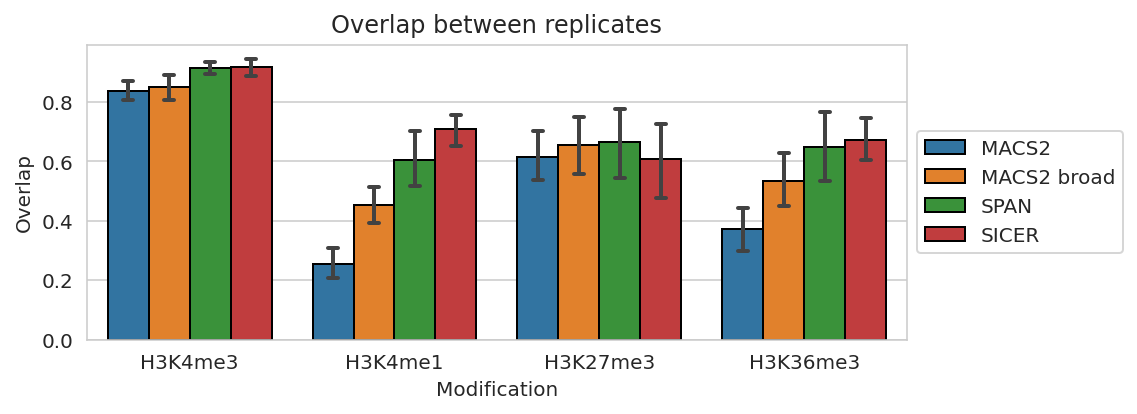

In [255]:
plt.figure(figsize=(8, 3))
plt.title(f'Overlap between replicates')
g_results = sns.barplot(data=ro, x='Modification', y='Overlap', hue='Tool',
                        capsize=.05, errwidth=2, edgecolor="black",
                        order=MODIFICATIONS,
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
# sns.boxplot(data=ro, x='Modification', y='Overlap', hue='Tool')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

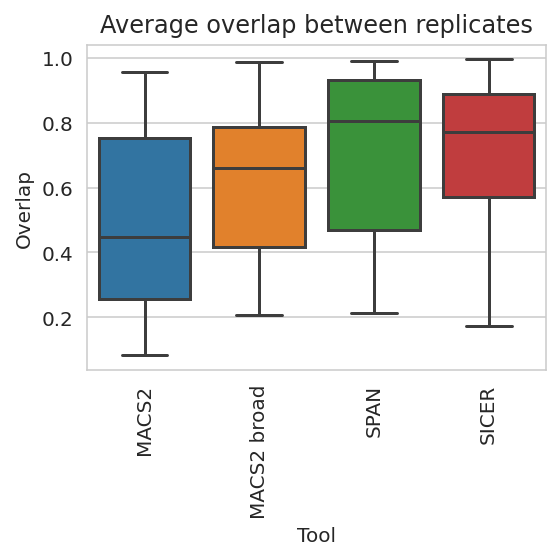

In [266]:
plt.figure(figsize=(4, 4))
plt.title(f'Average overlap between replicates')
g_results = sns.boxplot(data=ro, x='Tool', y='Overlap', showfliers=False,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_results.axes.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [257]:
rj = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'Jaccard'], dtype=object)
for _, row in reps_overlap.iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    length1 = row['length1']
    length2 = row['length2']
    intersection = row['intersect_length']
    jaccard = d(intersection, length1 + length2 - intersection)
    rj.loc[len(rj)] = (m, f'{rep1} vs {rep2}', tool, jaccard)
rj.sample(5)

,Modification,Replicate,Tool,Jaccard
44,H3K4me1,3_1 vs 4_1,MACS2,0.028390
46,H3K4me1,3_1 vs 4_3,MACS2,0.045979
20,H3K4me3,1_1 vs 2_1,SICER,0.692289
132,H3K36me3,2_2 vs 4_2,MACS2 broad,0.371028
27,H3K4me3,3_1 vs 5_2,SICER,0.605570


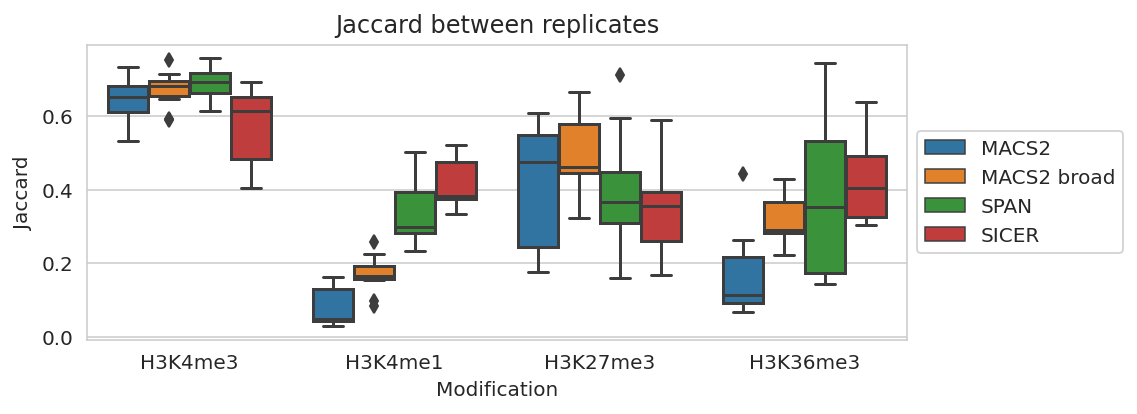

In [267]:
plt.figure(figsize=(8, 3))
plt.title('Jaccard between replicates')
g_results = sns.boxplot(data=rj, x='Modification', y='Jaccard', hue='Tool', 
                        order=MODIFICATIONS,
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        # capsize=.05, errwidth=2, edgecolor="black",
                        )
# sns.boxplot(data=rj, x='Modification', y='Jaccard', hue='Tool')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

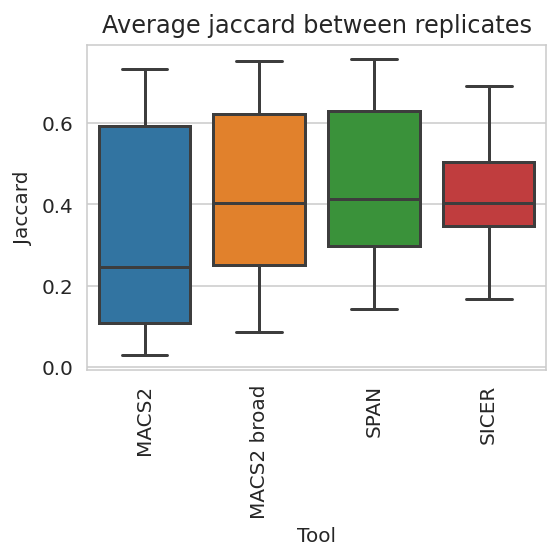

In [268]:
plt.figure(figsize=(4, 4))
plt.title(f'Average jaccard between replicates')
g_result = sns.boxplot(data=rj, x='Tool', y='Jaccard', showfliers=False,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_result.axes.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

# Consistency analysis between different tools

In [260]:
import tempfile

tools_overlap = pd.DataFrame(columns=['modification', 'rep', 'tool1', 'tool2',
                                      'peaks1', 'peaks2', 'length1', 'length2',
                                       'overlap1', 'overlap2', 'intersect'], dtype=object)

tools = list(sorted(set(dfa['name'])))
for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa.loc[dfa['modification'] == m]
    reps = list(sorted(set(tm['replicate'])))
    for rep in reps:
        for i in range(len(tools)):
            for j in range(i + 1, len(tools)):
                tool1, tool2 = tools[i], tools[j]
                t1 = tm.loc[(tm['name'] == tool1) & (tm['replicate'] == rep)]
                t2 = tm.loc[(tm['name'] == tool2) & (tm['replicate'] == rep)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                m = t1['modification'].values[0]
                file1 = sorted_file(t1['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                length1 = bedl(file1).sum()
                file2 = sorted_file(t2['file'].values[0])
                peaks2 = t2['peaks'].values[0]
                length2 = bedl(file2).sum()
                tf = tempfile.mktemp()
                ! bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                ! bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                ! bedtools intersect -a {file1} -b {file2} -wo > {tf}
                intersection_length = int(last_col(tf).sum())
                tools_overlap.loc[len(tools_overlap)] = \
                    (m, rep, tool1, tool2, peaks1, peaks2, length1, length2,
                     overlap1, overlap2, intersection_length)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


## Overlap between tools

In [261]:
to = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'overlap'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap1 = row['overlap1']
    overlap2 = row['overlap2']
    to.loc[len(to)] = (m, rep, tool1, tool2, d(overlap1, peaks1))
    to.loc[len(to)] = (m, rep, tool2, tool1, d(overlap2, peaks2))
to

,modification,replicate,tool1,tool2,overlap
0,H3K4me3,1_1,MACS2,MACS2 broad,1.000000
1,H3K4me3,1_1,MACS2 broad,MACS2,0.951963
2,H3K4me3,1_1,MACS2,SICER,0.993382
3,H3K4me3,1_1,SICER,MACS2,0.935288
4,H3K4me3,1_1,MACS2,SPAN,0.988492
...,...,...,...,...,...
379,H3K36me3,7_1,SICER,MACS2 broad,0.876408
380,H3K36me3,7_1,MACS2 broad,SPAN,0.783459
381,H3K36me3,7_1,SPAN,MACS2 broad,0.903241
382,H3K36me3,7_1,SICER,SPAN,0.859564


H3K4me3
H3K4me1
H3K27me3
H3K36me3


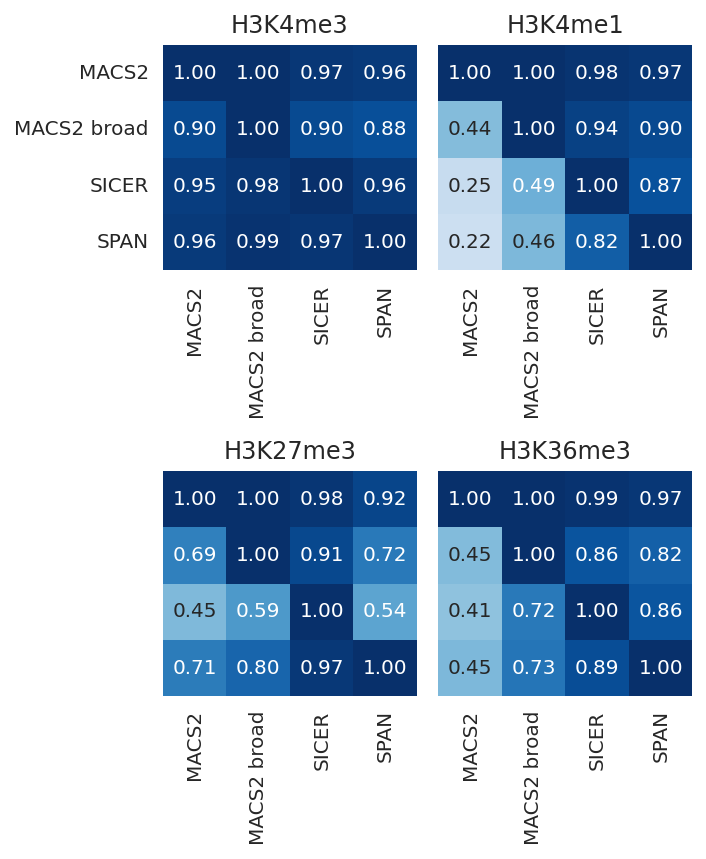

In [262]:
from math import ceil

#Heatmaps
fig = plt.figure(figsize=(5, 8))
for i, m in enumerate(MODIFICATIONS):
    print(m)
    tom = to[to['modification'] == m].groupby(['tool1', 'tool2'])['overlap'].mean().reset_index().copy()
    tomp = tom.pivot(index='tool1', columns='tool2', values='overlap').fillna(1.0)
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tomp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.2f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

## Jaccard between tools

In [263]:
tj = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'jaccard'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    length1 = row['length1']
    length2 = row['length2']
    intersection = row['intersect']
    jaccard = d(intersection, length1 + length2 - intersection)
    tj.loc[len(tj)] = (m, rep, tool1, tool2, jaccard)

H3K4me3
H3K4me1
H3K27me3
H3K36me3


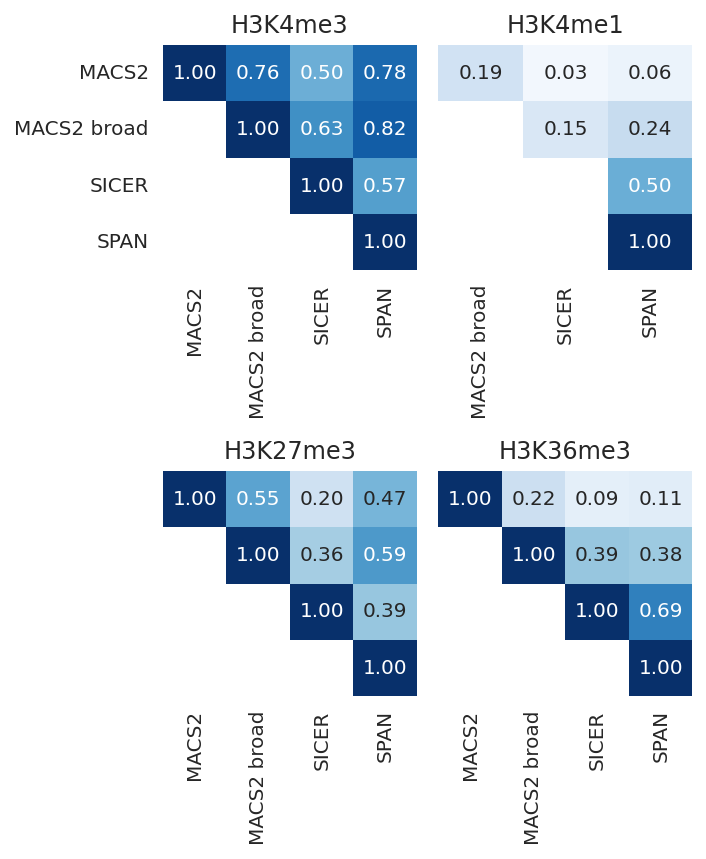

In [264]:
#Heatmaps
fig = plt.figure(figsize=(5, 8))

for i, m in enumerate(MODIFICATIONS):
    print(m)
    tjm = tj[tj['modification'] == m].copy()
    for t in tools:
        tjm.loc[len(tjm)] = (m, 'rep', t, t, 1.0)
    tjm = tjm.groupby(['tool1', 'tool2'])['jaccard'].mean().reset_index().copy()
    tjmp = tjm.pivot(index='tool1', columns='tool2', values='jaccard')
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tjmp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.2f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()